<a href="https://colab.research.google.com/github/Thagio/Bayesian_Modeling/blob/master/01_pymc3_General_API_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

参考リンク  
https://docs.pymc.io/notebooks/api_quickstart.html

In [1]:
INSTALL = True

if INSTALL:
  !pip install arviz
  !pip install pymc3==3.9.3

Requirement already up-to-date: pymc3==3.9.3 in /usr/local/lib/python3.6/dist-packages (3.9.3)


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
print('Running on ArviZ v{}'.format(az.__version__))

Running on PyMC3 v3.9.3
Running on ArviZ v0.10.0


# 1. モデル構築
RVsはRandom Variablesの略


In [4]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

In [5]:
# モデルに含まれる確率変数を確認
model.basic_RVs

[mu, obs]

In [6]:
# 多分、observedがない。乱数生成される確率生成される変数
model.free_RVs

[mu]

In [7]:
model.observed_RVs

[obs]

In [8]:
model.logp({"mu": 0})

array(-131.8586435)

logpで行った設計上の選択に注目してみましょう。上で見たように、logpは引数で呼び出されているので、モデルインスタンスのメソッドです。より正確には、モデルの現在の状態に基づいて、あるいはlogpへの引数として与えられた状態に基づいて、関数をまとめます（下記の例を参照）。

様々な理由から、モデルインスタンスは静的ではないと仮定しています。内部ループでlogpを使用する必要があり、静的である必要がある場合は、logp = model.logpのようなものを使用してください。以下に例を示します - キャッシング効果と高速化に注意してください。

In [9]:
%timeit model.logp({mu: 0.1})
logp = model.logp
%timeit logp({mu: 0.1})

10 loops, best of 3: 74.1 ms per loop
The slowest run took 10.31 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 21.1 µs per loop


# 2. 確率分布  
すべての確率的プログラムは、観測された確率変数と観測されていない確率変数(RV)から構成される。観測されたRVは尤度分布によって定義され、観測されていないRVは先行分布によって定義されます。PyMC3では、確率分布はメインモジュール空間から利用できます。

In [10]:
help(pm.Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Univariate normal log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(-5, 5, 1000)
 |      mus = [0., 0., 0., -2.]
 |      sigmas = [0.4, 1., 2., 0.4]
 |      for mu, sigma in zip(mus, sigmas):
 |          pdf = st.norm.pdf(x, mu, sigma)
 |          plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(m

In [11]:
dir(pm.distributions.mixture)

['Discrete',
 'Distribution',
 'Iterable',
 'Mixture',
 'Normal',
 'NormalMixture',
 '_DrawValuesContext',
 '_DrawValuesContextBlocker',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_conversion_map',
 'all_discrete',
 'bound',
 'broadcast_distribution_samples',
 'draw_values',
 'generate_samples',
 'get_tau_sigma',
 'get_variable_name',
 'logsumexp',
 'np',
 'random_choice',
 'theano',
 'to_tuple',
 'tt',
 'warnings']

In [12]:
## Unobserved Variable
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)

In [13]:
x.logp({"x": 0})

array(-0.91893853)

In [14]:
## Observed Variable
# Observed RVs are defined just like unobserved RVs but require data to be passed into the observed keyword argument:

with pm.Model():
    obs = pm.Normal("x", mu=0, sigma=1, observed=np.random.randn(100))

→ observed supports lists, numpy.ndarray, theano and pandas data structures.

→　observed引数には、複数のデータ型が使えるらしい。


In [15]:
## Deterministic transforms¶
# PyMC3 allows you to freely do algebra with RVs in all kinds of ways:

with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x ** 2
    sined = pm.math.sin(x)

In [16]:
# While these transformations work seamlessly, their results are not stored automatically.
#  Thus, if you want to keep track of a transformed variable, you have to use pm.Deterministic:

with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    plus_2 = pm.Deterministic("x plus 2", x + 2)

In [17]:
## Automatic transforms of bounded RVs¶
## In order to sample models more efficiently, PyMC3 automatically transforms bounded RVs to be unbounded.

with pm.Model() as model:
    x = pm.Uniform("x", lower=0, upper=1)

In [18]:
## model.free_RVsを見ると、xがあることが期待されるんだが、bounded RVsを使うとそうなってはおらず。
## 確認→

model.free_RVs

[x_interval__]

x_interval__ は、-inf と +inf の間のパラメータ値を受け入れるように変換された x を表します。上限と下限の場合、LogOdds変換が適用されます。この変換された空間でサンプリングを行うと、サンプラーがより簡単になります。PyMC3 はまた、変換されていない拘束されたパラメータの追跡も行います。これらは一般的な決定論です（上記参照）

→　確率分布を切断したときは、何かしらの変換を実施するとサンプリングがうまくいく


In [19]:
model.deterministics

[x]

When displaying results, PyMC3 will usually hide transformed parameters. You can pass the include_transformed=True parameter to many functions to see the transformed parameters that are used for sampling.

You can also turn transforms off:

In [20]:
with pm.Model() as model:
    x = pm.Uniform("x", lower=0, upper=1, transform=None)

print(model.free_RVs)

[x]


In [21]:
import pymc3.distributions.transforms as tr

with pm.Model() as model:
    # use the default log transformation
    x1 = pm.Gamma("x1", alpha=1, beta=1)
    # specify a different transformation
    x2 = pm.Gamma("x2", alpha=1, beta=1, transform=tr.log_exp_m1)

print("The default transformation of x1 is: " + x1.transformation.name)
print("The user specified transformation of x2 is: " + x2.transformation.name)

The default transformation of x1 is: log
The user specified transformation of x2 is: log_exp_m1


Transformed distributions and changes of variables¶
PyMC3 does not provide explicit functionality to transform one distribution to another. Instead, a dedicated distribution is usually created in consideration of optimising performance. However, users can still create transformed distribution by passing the inverse transformation to transform kwarg. Take the classical textbook example of LogNormal: $log(y)∼Normal(μ,σ)$


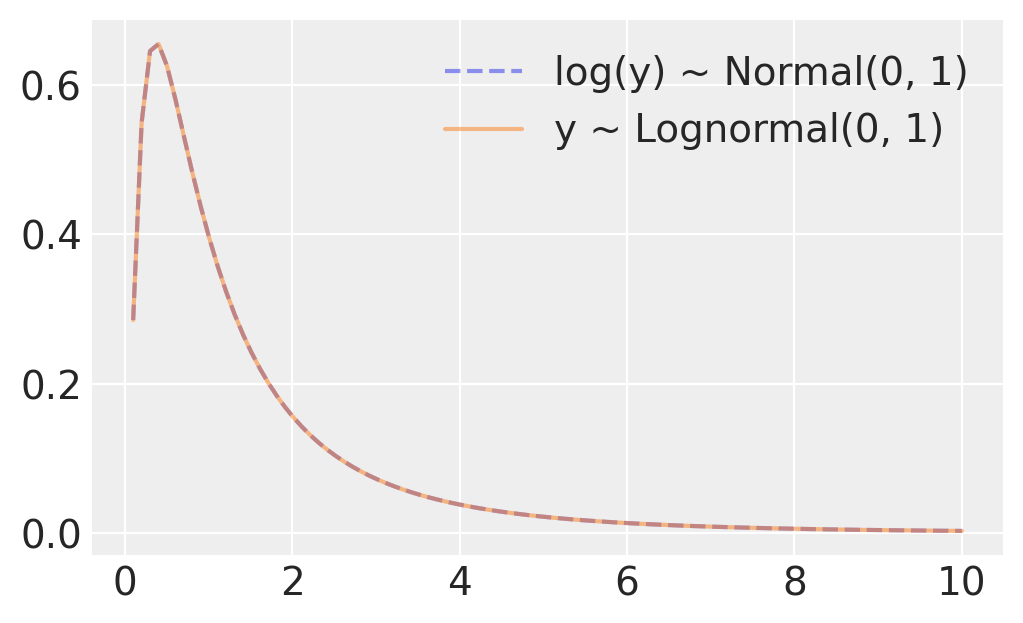

In [22]:

class Exp(tr.ElemwiseTransform):
    name = "exp"

    def backward(self, x):
        return tt.log(x)

    def forward(self, x):
        return tt.exp(x)

    def jacobian_det(self, x):
        return -tt.log(x)


with pm.Model() as model:
    x1 = pm.Normal("x1", 0.0, 1.0, transform=Exp())
    x2 = pm.Lognormal("x2", 0.0, 1.0)

lognorm1 = model.named_vars["x1_exp__"]
lognorm2 = model.named_vars["x2"]

_, ax = plt.subplots(1, 1, figsize=(5, 3))
x = np.linspace(0.0, 10.0, 100)
ax.plot(
    x,
    np.exp(lognorm1.distribution.logp(x).eval()),
    "--",
    alpha=0.5,
    label="log(y) ~ Normal(0, 1)",
)
ax.plot(
    x,
    np.exp(lognorm2.distribution.logp(x).eval()),
    alpha=0.5,
    label="y ~ Lognormal(0, 1)",
)
plt.legend();

In [23]:
model.free_RVs

[x1_exp__, x2_log__]

上から、モデルの名前付き変数x1_exp__が対数正規分布であることに注目してください。
同様の方法で、ある分布に従った順序付きRVを作ることができます。例えば、順序変換とlogodds変換をChainで組み合わせて、x1,x2∼Uniform(0,1)とx1<x2を満たす2次元RVを作ることができます。

In [24]:
Order = tr.Ordered()
Logodd = tr.LogOdds()
chain_tran = tr.Chain([Logodd, Order])

with pm.Model() as m0:
   # testvalでは、確率変数の開始点を指定できるらしい。異常な値が生まれないようにするらしい。
    x = pm.Uniform("x", 0.0, 1.0, shape=2, transform=chain_tran, testval=[0.1, 0.9])
    trace = pm.sample(5000, tune=1000, progressbar=False)#, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x]
Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  import sys


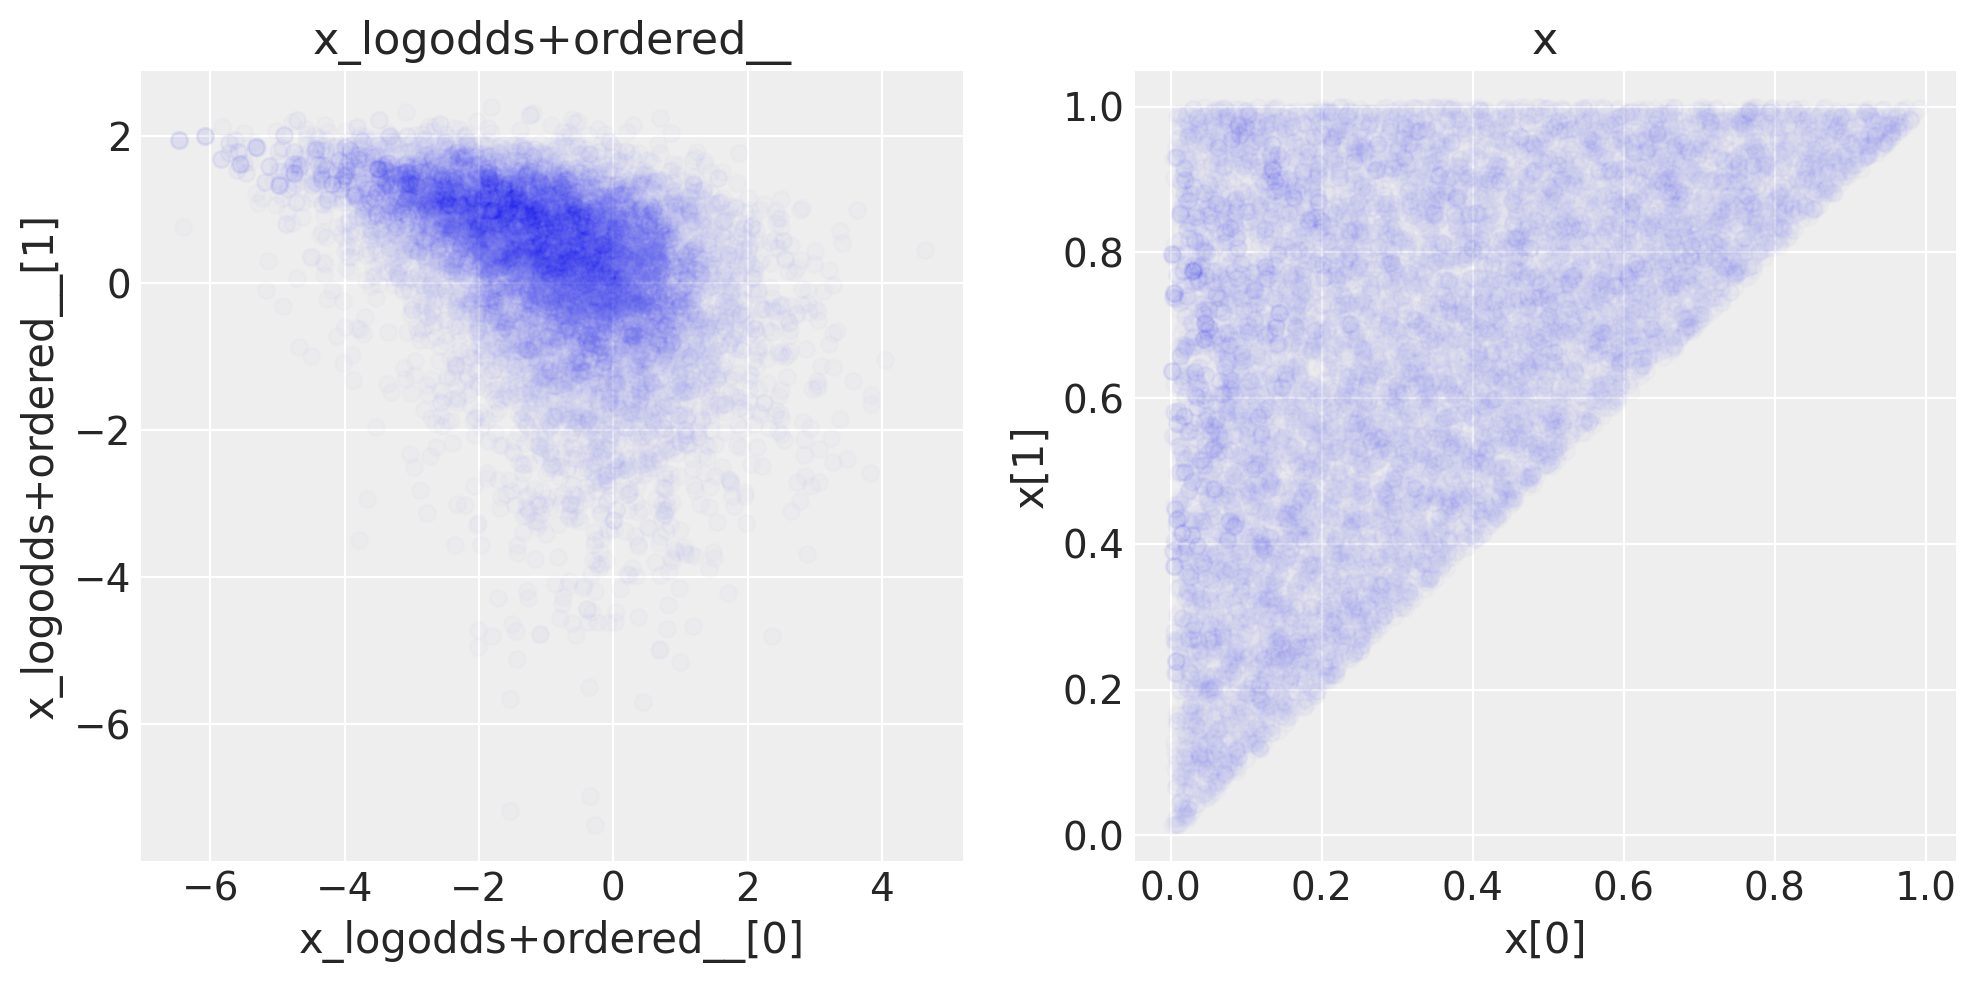

In [25]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
for ivar, varname in enumerate(trace.varnames):
    ax[ivar].scatter(trace[varname][:, 0], trace[varname][:, 1], alpha=0.01)
    ax[ivar].set_xlabel(varname + "[0]")
    ax[ivar].set_ylabel(varname + "[1]")
    ax[ivar].set_title(varname)
plt.tight_layout()

In [26]:
# Lists of RVs / higher-dimensional RVs¶
# Above we have seen how to create scalar RVs.
#  In many models, you want multiple RVs. There is a tendency (mainly inherited from PyMC 2.x) to create list of RVs, like this:

In [27]:
with pm.Model() as m1:
    # bad:
    x = [pm.Normal("x_{}".format(i), mu=0, sigma=1) for i in range(10)]

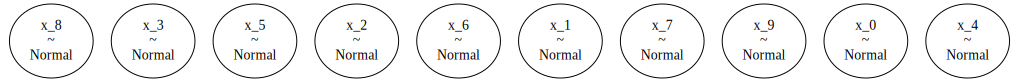

In [28]:
pm.model_to_graphviz(m1)

リスト内包表記を使って、確率変数を定義することができるが、結構遅くなるので、おすすめしない。以下のshape引数を使って、確率変数を定義するのがおすすめ。 


In [29]:
with pm.Model() as model:
    # good:
    x = pm.Normal("x", mu=0, sigma=1, shape=10)

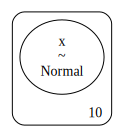

In [30]:
pm.model_to_graphviz(model)

In [31]:
with model:
    y = x[0] * x[1]  # full indexing is supported
    x.dot(x.T)  # Linear algebra is supported

In [32]:
# Initialization with test_values¶
# While PyMC3 tries to automatically initialize models it is sometimes helpful to define initial values for RVs. This can be done via the testval kwarg:

with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1, shape=5)

x.tag.test_value

array([0., 0., 0., 0., 0.])

In [33]:
testval = np.random.randn(5)

print(testval)

with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1, shape=5, testval=testval)

x.tag.test_value

[-0.48365712 -0.40493881  1.4170974   1.85037672  0.57399066]


array([-0.48365712, -0.40493881,  1.4170974 ,  1.85037672,  0.57399066])

→ モデルのデバッグとかに、testvalが使えるかも。
あと、モデルの初期化に使えて、burn-inの期間が減るかも。 

# 3. Inference¶
Once we have defined our model, we have to perform inference to approximate the posterior distribution. PyMC3 supports two broad classes of inference: sampling and variational inference.

3.1 Sampling¶

In [34]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    idata = pm.sample(2000, tune=1500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 4 seconds.


ご覧のように、連続モデルでは、PyMC3 は NUTS サンプラーを割り当てますが、これは複雑なモデルでも非常に効率的です。また、PyMC3は、サンプラーの良い開始パラメータを見つけるためにチューニングを実行します。ここでは、各連鎖の事後処理から2000個のサンプルを抽出し、1500回の繰り返しでサンプラーがパラメータを調整できるようにしています。コア数を設定していない場合、チェーンの数は利用可能なCPUコア数から決定されます

In [36]:
idata.posterior.dims

Frozen(SortedKeysDict({'chain': 2, 'draw': 2000}))

The tuning samples are discarded by default. With discard_tuned_samples=False they can be kept and end up in a special property of the InferenceData object.

You can also run multiple chains in parallel using the chains and cores kwargs:

In [37]:

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    idata = pm.sample(cores=4, chains=6, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [mu]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 9 seconds.


In [38]:
idata.posterior["mu"].shape

(6, 1000)

In [39]:
# get values of a single chain
idata.posterior["mu"].sel(chain=1).shape

(1000,)

In [40]:
## サンプラーの種類はいろいろある。
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'DEMetropolisZ',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'Slice']

In [ ]:
NUTSの他によく使われるステップ法はMetropolisとSliceである。ほとんどすべての連続モデルでは、 ``NUTS`` が好まれるべきです。サンプル化が難しいモデルでは、NUTSが非常に遅くなるため、多くのユーザが代わりにMetropolisを使用しています。しかし、この方法が成功することはほとんどありません。NUTSは単純なモデルでは高速ですが、モデルが非常に複雑であったり、初期化が不十分であったりすると遅くなります。NUTSが困難な複雑なモデルの場合、Metropolisは高速ではありますが、有効サンプルサイズが非常に小さくなったり、適切に収束しなかったりします。より良いアプローチは、代わりにNUTSの初期化を改善するか、モデルを再パラメータ化することです。

完全性のために、他のサンプリング方法をsampleに渡すことができます。

In [41]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    step = pm.Metropolis()
    trace = pm.sample(1000, step=step)

Sequential sampling (2 chains in 1 job)
Metropolis: [mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [43]:
##　確率変数ゴトにサンプラーを変えることができる
## 離散やバイナリ毎に変えても良い。

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

    step1 = pm.Metropolis(vars=[mu])
    step2 = pm.Slice(vars=[sd])
    idata = pm.sample(10000, step=[step1, step2], cores=4, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Slice: [sd]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 40 seconds.
The number of effective samples is smaller than 25% for some parameters.


# 3.2 Analyze sampling results¶
The most common used plot to analyze sampling results is the so-called trace-plot:

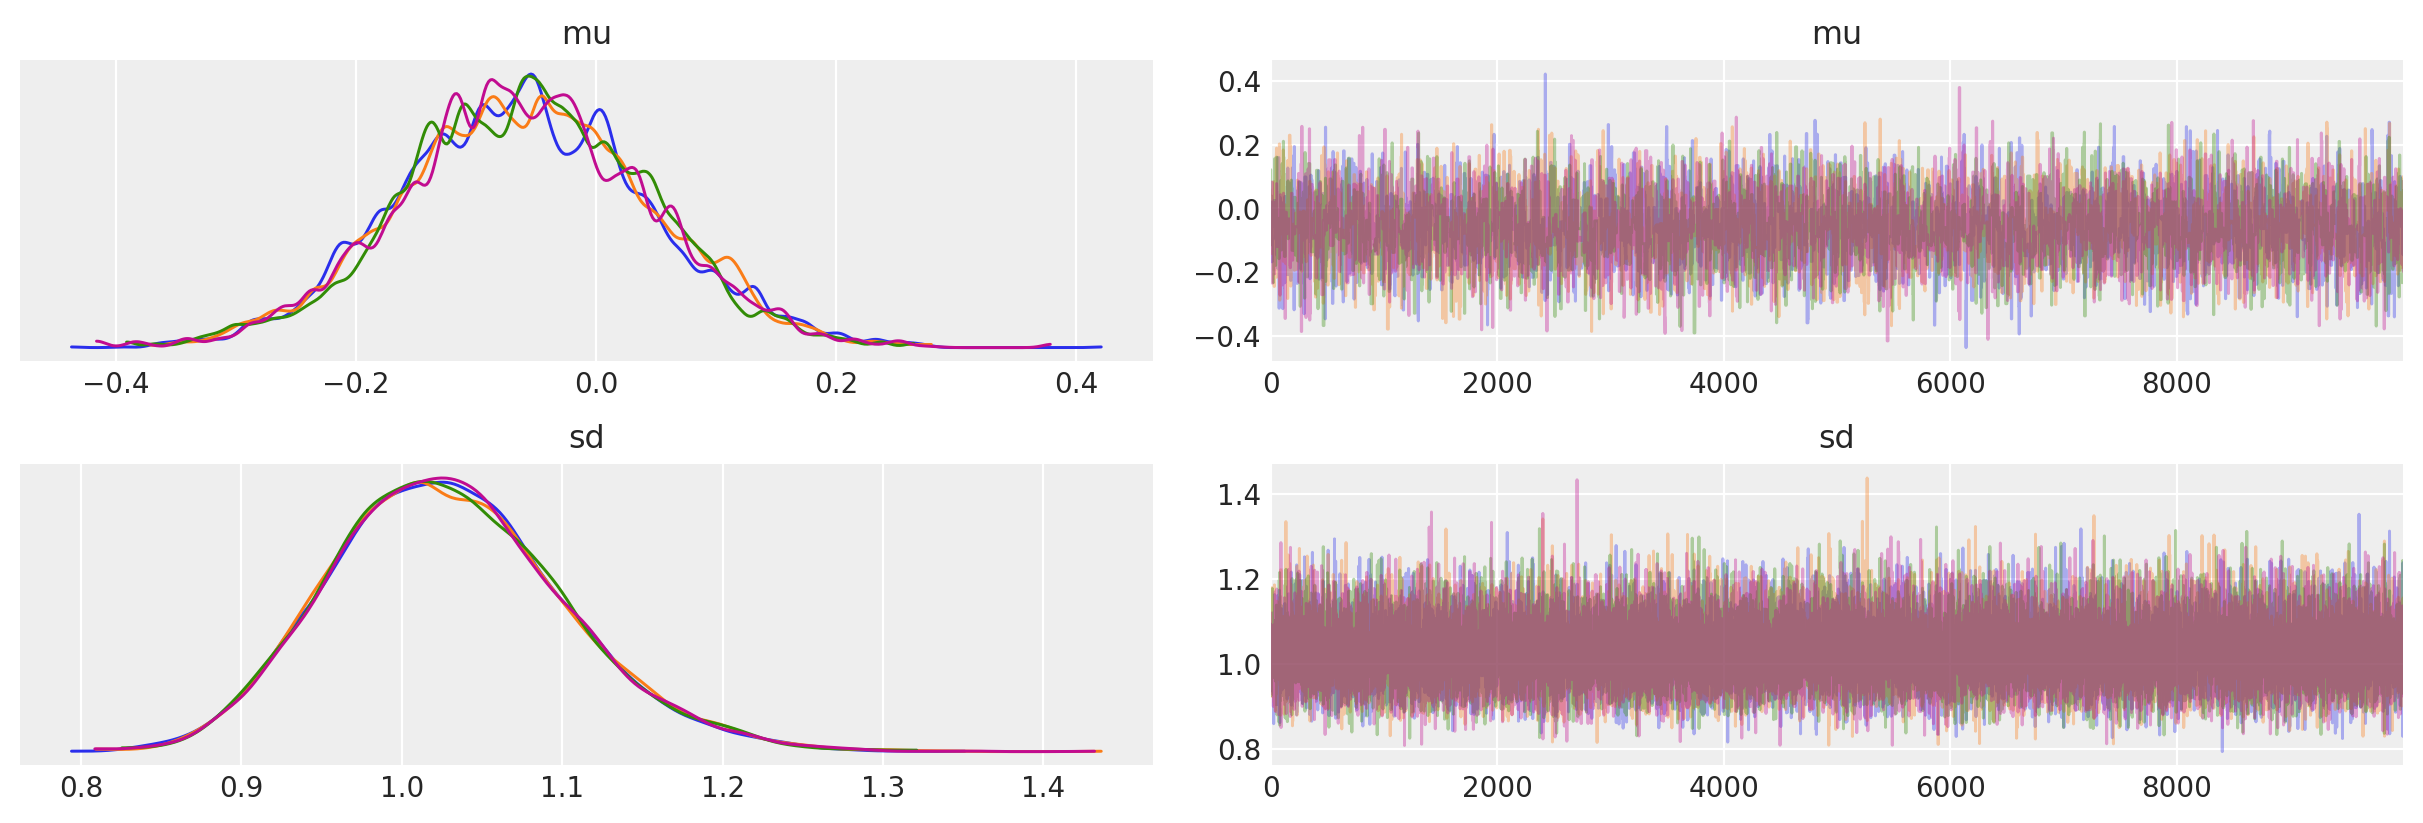

In [44]:
az.plot_trace(idata);

In [45]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-0.060,0.103,-0.247,0.142,0.001,0.001,5977.0,5447.0,5988.0,6544.0,1.0
sd,1.029,0.073,0.894,1.167,0.000,0.000,36773.0,35840.0,38020.0,29573.0,1.0


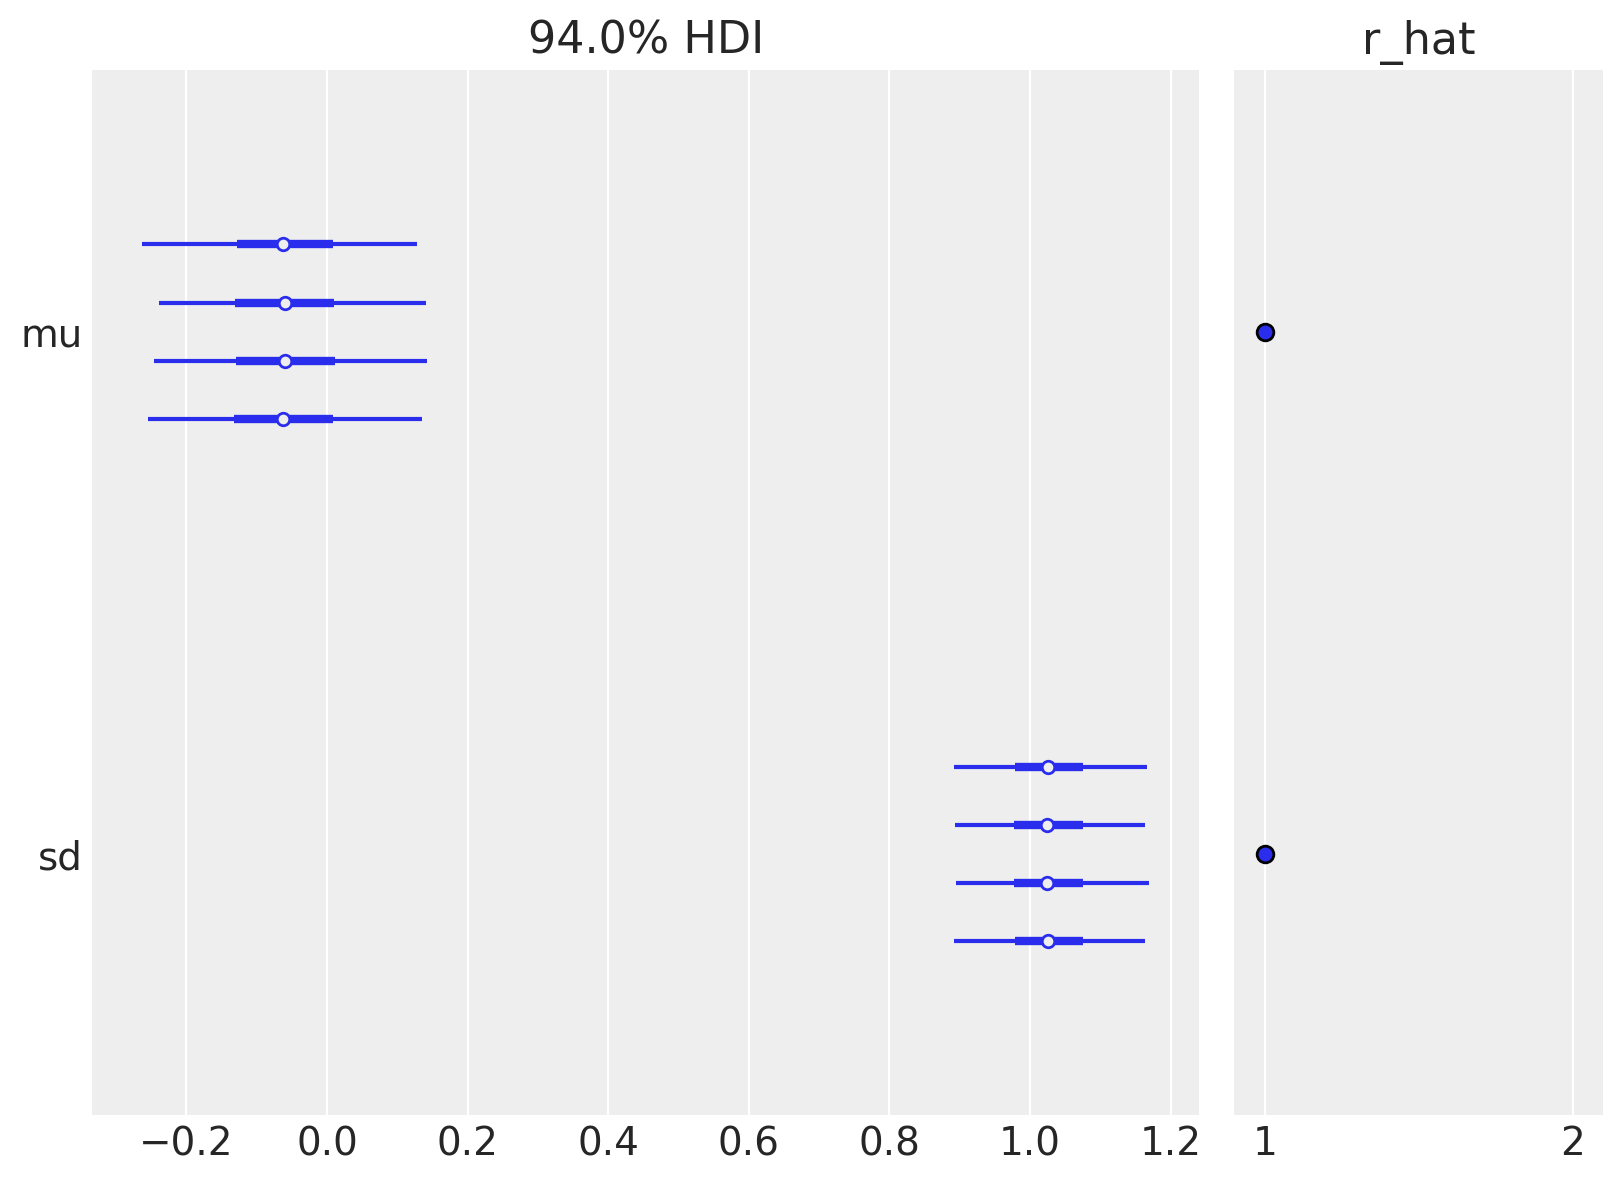

In [47]:
az.plot_forest(idata, r_hat=True);

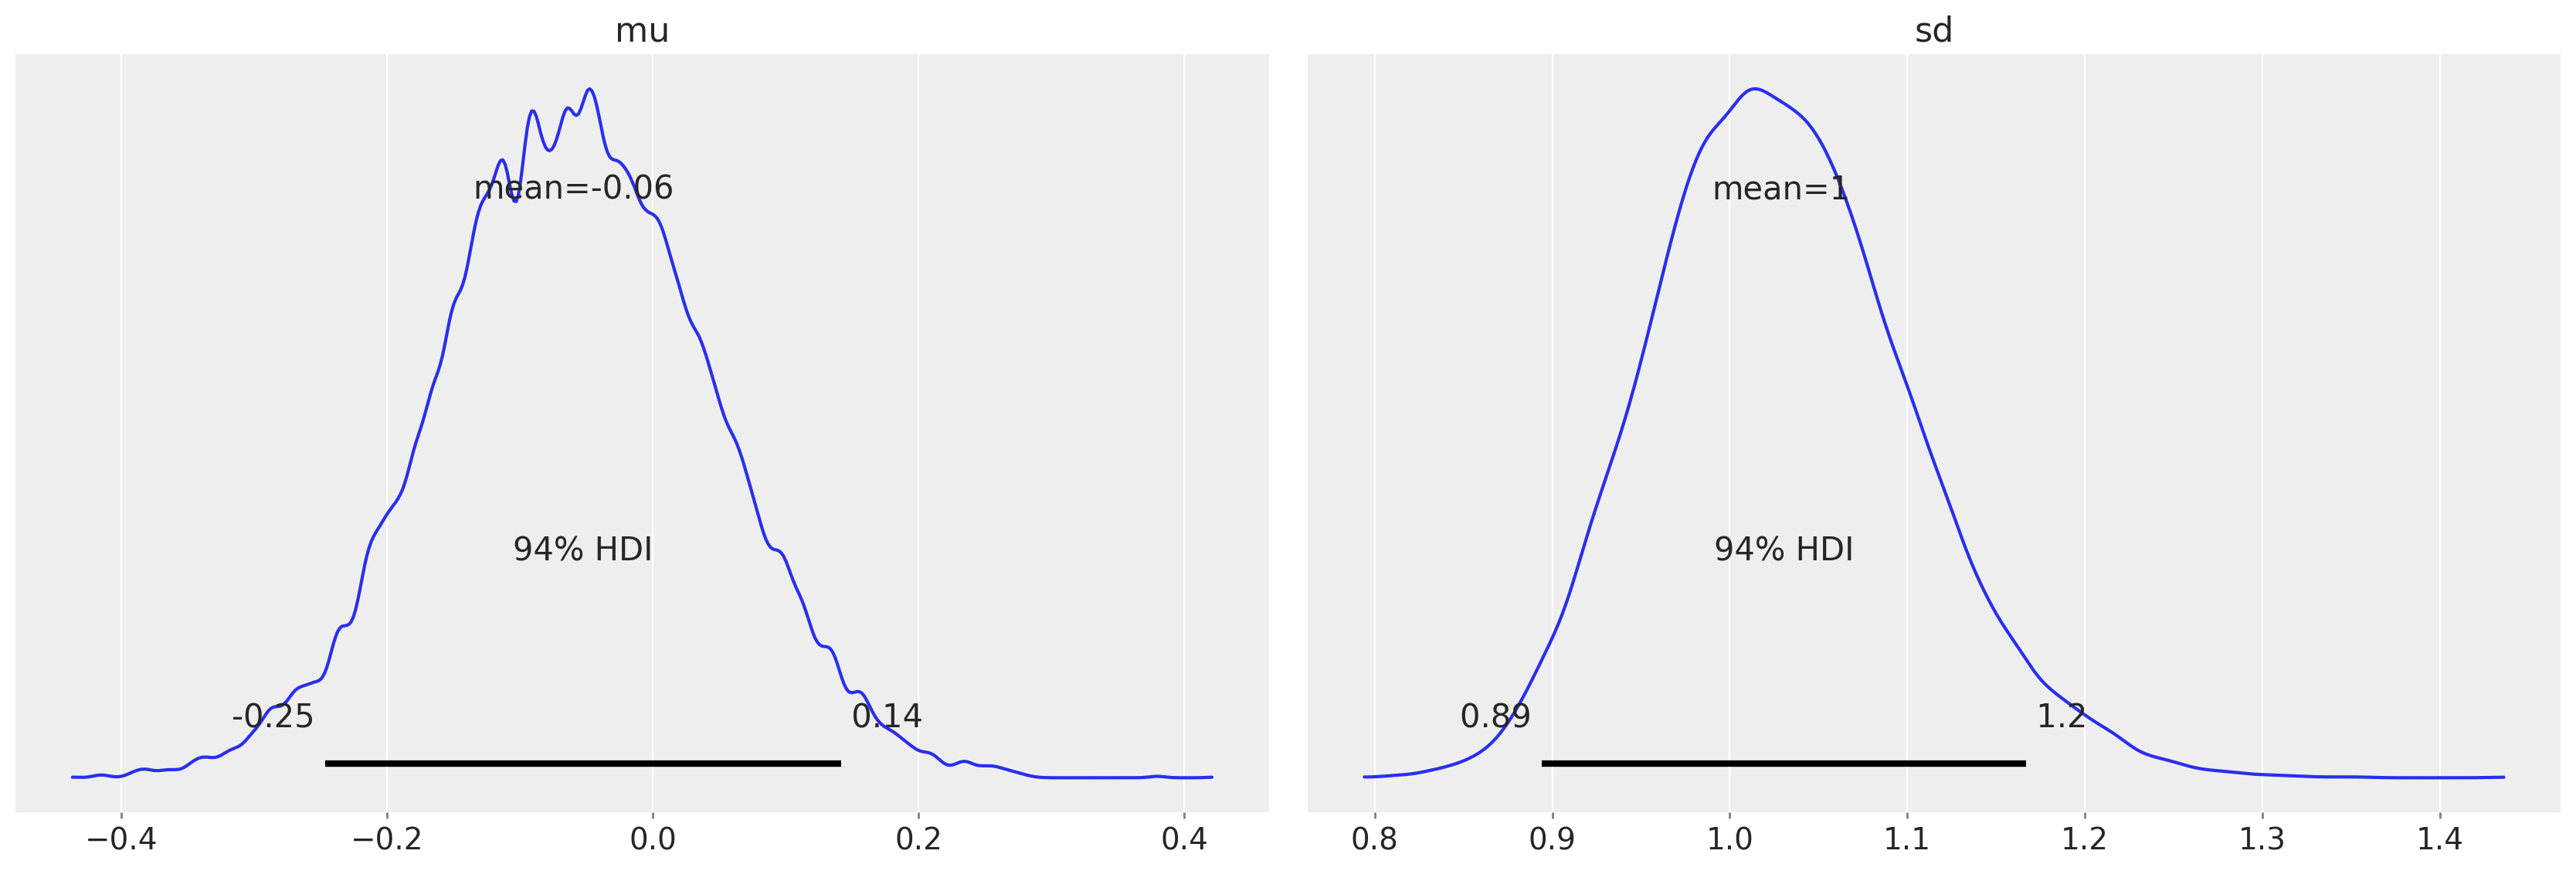

In [48]:
az.plot_posterior(idata);

In [ ]:
# For high-dimensional models it becomes cumbersome to look at all parameter’s traces. 
# When using NUTS we can look at the energy plot to assess problems of convergence:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


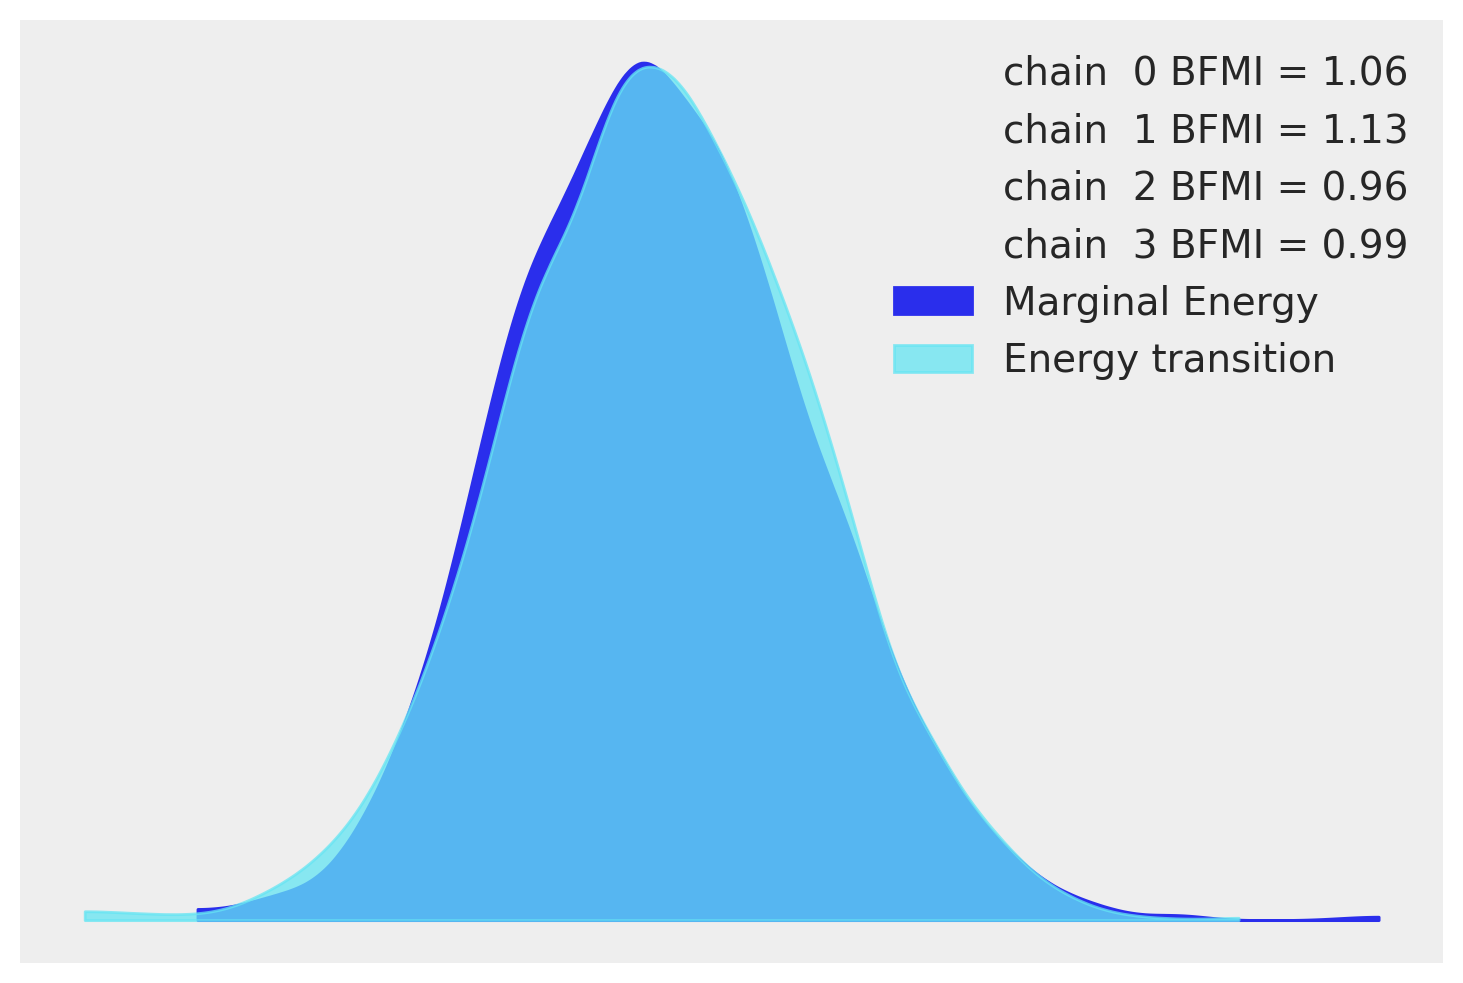

In [49]:
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1, shape=100)
    idata = pm.sample(cores=4, return_inferencedata=True)

az.plot_energy(idata);

→　どうなっていれば収束と判断できるのだろうか？  
→　以下のリンク参考  
https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html

https://docs.pymc.io/notebooks/sampler-stats.html

# 4. Posterior Predictive Sampling¶

In [50]:
data = np.random.randn(100)
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=data)

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [51]:
with model:
    post_pred = pm.sample_posterior_predictive(idata.posterior)
# add posterior predictive to the InferenceData
az.concat(idata, az.from_pymc3(posterior_predictive=post_pred), inplace=True)

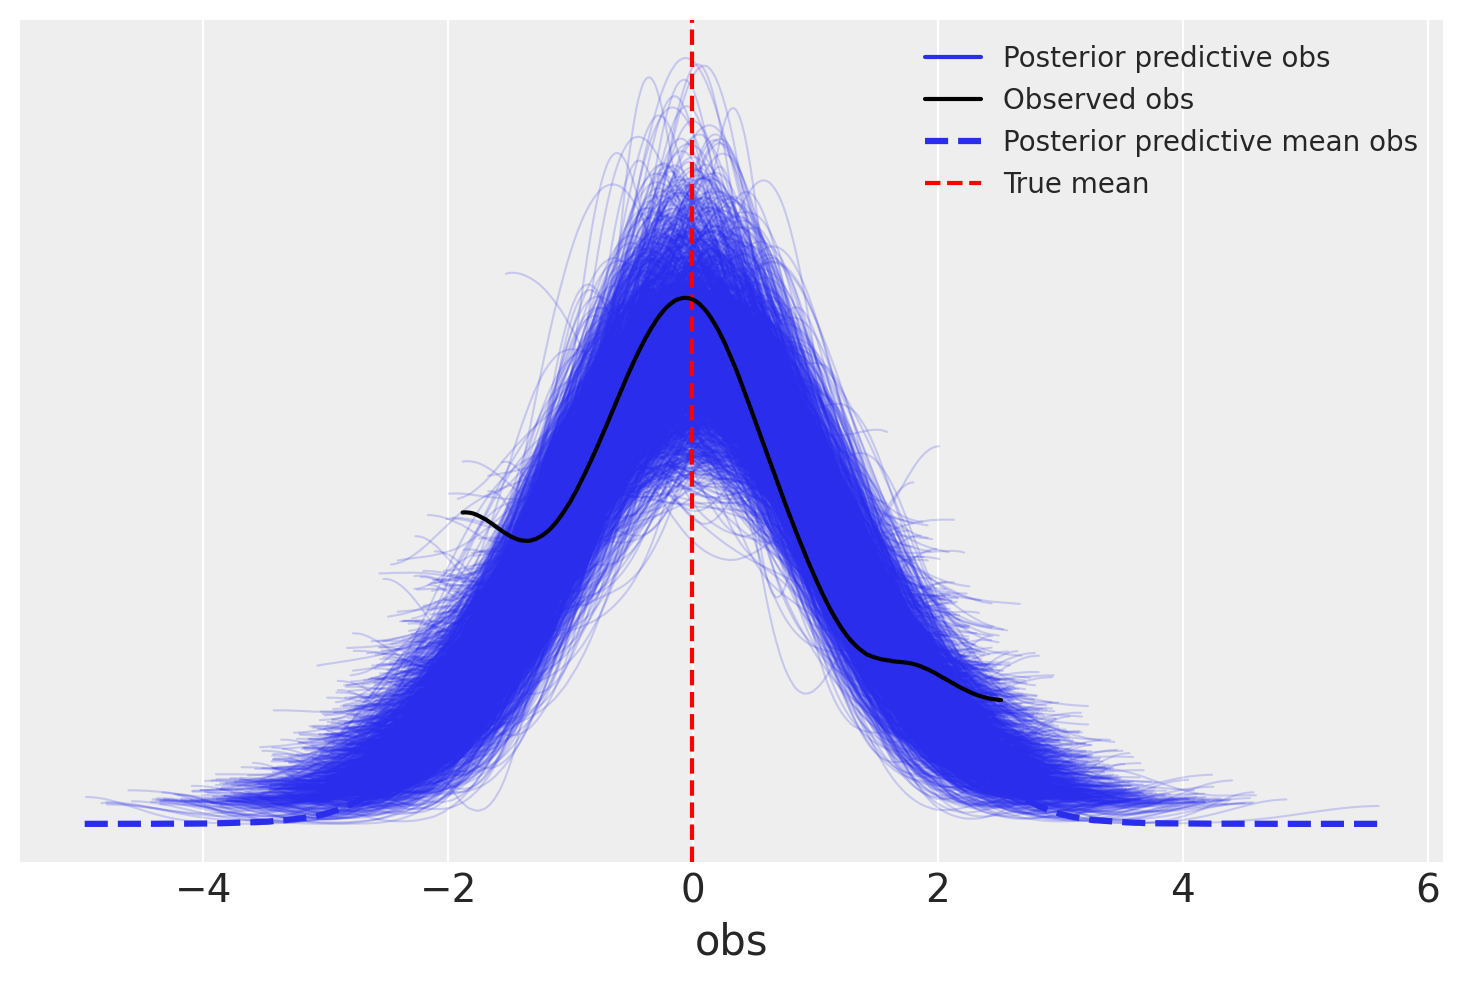

In [52]:
fig, ax = plt.subplots()
az.plot_ppc(idata, ax=ax)
ax.axvline(data.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);

4.1 Predicting on hold-out data  

In many cases you want to predict on unseen / hold-out data. This is especially relevant in Probabilistic Machine Learning and Bayesian Deep Learning. We recently improved the API in this regard with the pm.Data container. It is a wrapper around a theano.shared variable whose values can be changed later. Otherwise they can be passed into PyMC3 just like any other numpy array or tensor.

This distinction is significant since internally all models in PyMC3 are giant symbolic expressions. When you pass data directly into a model, you are giving Theano permission to treat this data as a constant and optimize it away as it sees fit. If you need to change this data later you might not have a way to point at it in the symbolic expression. Using theano.shared offers a way to point to a place in that symbolic expression, and change what is there.


In [53]:
x = np.random.randn(100)
y = x > 0

with pm.Model() as model:
    # create shared variables that can be changed later on
    x_shared = pm.Data("x_obs", x)
    y_shared = pm.Data("y_obs", y)

    coeff = pm.Normal("x", mu=0, sigma=1)
    logistic = pm.math.sigmoid(coeff * x_shared)
    pm.Bernoulli("obs", p=logistic, observed=y_shared)
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.8891624630079844, but should be close to 0.8. Try to increase the number of tuning steps.


In [54]:
with model:
    # change the value and shape of the data
    pm.set_data({
        "x_obs": [-1, 0, 1.0],
        # use dummy values with the same shape:
        "y_obs": [0, 0, 0],
    })

    post_pred = pm.sample_posterior_predictive(idata.posterior)

In [55]:
post_pred["obs"].mean(axis=0)

array([0.0205, 0.5095, 0.976 ])

In [61]:
from pprint import pprint
pprint(post_pred["obs"])

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 1],
       ...,
       [0, 1, 1],
       [0, 1, 1],
       [0, 0, 1]])
